In [169]:
import sys
import csv
import os
import pandas as pd
import numpy as np
import decimal
from pyneuroml import pynml
from pyneuroml.pynml import print_comment_v
from pyneuroml.lems import LEMSSimulation
import neuroml as nml
import neuroml.writers as writers
import random
random.seed(12345)
%matplotlib inline

In [187]:
from platform import python_version

print(python_version())

3.7.6


In [185]:
#Create NeuroML files
output_dict = {}


start = 20
stop = 37
step = 17
temp_range = np.arange(start, stop + step, step)
cellName = "C10"

for i in temp_range:
    i = round(i,2)
    nml_doc = nml.NeuroMLDocument(id="net")

    #Include cell file
    incl = nml.IncludeType(href=cellName+"_scaled_exp_resample_5.cell.nml")
    nml_doc.includes.append(incl)

    #Create network
    net = nml.Network(id="net", type="networkWithTemperature", temperature=str(i)+"degC")
    nml_doc.networks.append(net)

    #Create population
    pop = nml.Population(id="pop", component=cellName, type="populationList", size="1")
    net.populations.append(pop)

    loc = nml.Location(x="0", y="0", z="0")

    inst = nml.Instance(id="0", location=loc)
    pop.instances.append(inst)
  
    #Create pulse generator
    t_delay = 200
    t_duration = 50
    
    pg = nml.PulseGenerator(id="iclamp0", delay=str(t_delay)+"ms", duration=str(t_duration)+"ms", amplitude="-1nA")
    nml_doc.pulse_generators.append(pg)

    #Add pg to cell
    il = nml.InputList(id="clamps", component=pg.id, populations="pop")
    ip = nml.Input(id="0", target="../pop/0/"+str(cellName), segmentId="0", destination="synapses")
    il.input.append(ip)
    net.input_lists.append(il)

    nml_file = "nml_"+cellName+".net.nml"
    writers.NeuroMLWriter.write(nml_doc, nml_file)

    #print("Written network file to: "+nml_file)

    from neuroml.utils import validate_neuroml2
    validate_neuroml2(nml_file)

    ref = "Test"
    sim_id = "Vm_%s"%ref
    sim_dur_ms = 1000
    dt = 0.05
    segment = [0, 1]
    quantity = []
    for s in segment:
        quantity.append("pop/0/"+cellName+"/"+str(s)+"/v")
    target = 'net'

    ls = LEMSSimulation(sim_id, sim_dur_ms, dt, target = target)
    ls.include_neuroml2_file("nml_"+cellName+".net.nml")
    #ls.assign_simulation_target('net')

    disp0 = 'display0'
    ls.create_display(disp0, "Spiking pattern", "-90", "50")
    for j in range(len(quantity)):
        ls.add_line_to_display(disp0, segment[j], quantity[j])

    of0 = 'Volts_file'
    ls.create_output_file(of0, "%s.v.dat"%sim_id)
    for j in range(len(quantity)): 
        ls.add_column_to_output_file(of0, segment[j], quantity[j])
        print(segment[j])
        print(quantity[j])
        
    fn = "LEMS_%s.xml"%sim_id
    ls.save_to_file(file_name=fn)

    example_lems_file = '/home/jovyan/work/NeuroML_Examples/Naomi/LEMS_Vm_Test.xml'

    out_dir,rel_filename = os.path.split(example_lems_file)
    #print(out_dir)
    #print(rel_filename)

    results_dict = pynml.run_lems_with_jneuroml_neuron(
        rel_filename, verbose=False, nogui=True, load_saved_data=True, exec_in_dir=out_dir,
        max_memory='400M')
    
    print( results_dict.keys() )
    #print( 'Recorded points: ', len(results_dict['t']) )
    
    for q in quantity:
        results_dict[str(q)+"."+str(i)+'degC'] = results_dict.pop(q) 
    output_dict.update(results_dict)
    print(output_dict.keys())

Validating nml_C10.net.nml against /opt/conda/lib/python3.7/site-packages/neuroml/nml/NeuroML_v2.1.xsd
It's valid!
0
pop/0/C10/0/v
1
pop/0/C10/1/v
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/NeuroML_Examples/Naomi/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/NeuroML_Examples/Naomi, cwd: /home/jovyan/work/NeuroML_Examples/Naomi
dict_keys(['t', 'pop/0/C10/0/v', 'pop/0/C10/1/v'])
dict_keys(['t', 'pop/0/C10/0/v.20degC', 'pop/0/C10/1/v.20degC'])
Validating nml_C10.net.nml against /opt/conda/lib/python3.7/site-packages/neuroml/nml/NeuroML_v2.1.xsd
It's valid!
0
pop/0/C10/0/v
1
pop/0/C10/1/v
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/NeuroML_Examples/Naomi/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/NeuroML_Examples/Naomi, cwd: /home/jovyan/work/NeuroML_Exa

In [77]:
quantity = []
for s in segment:
    quantity.append("pop/0/C51A/"+str(s)+"/v")
for i in range(len(quantity)):
    print(i)

0
1


In [118]:
print(output_dict.keys())

dict_keys(['t', 'pop/0/C10/0/v.20degC', 'pop/0/C10/310/v.20degC', 'pop/0/C10/0/v.37degC', 'pop/0/C10/310/v.37degC'])


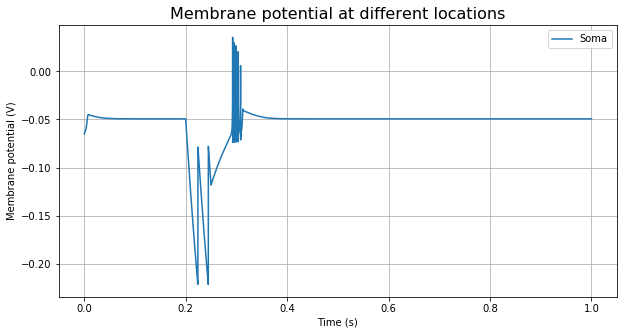

KeyError: 'pop/0/C10/310/v.37degC'

In [186]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

temp = 37

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['axes.titlesize'] = 16

plt.xlabel('Time (s)')
plt.ylabel('Membrane potential (V)')
plt.title('Membrane potential at different locations')
plt.grid(True)

for key in output_dict:
    if key == 't':
        # no need to plot sim time against sim time
        continue
    if key == "pop/0/"+cellName+"/0/v."+str(temp)+"degC" or key == "pop/0/"+cellName+"/310/v."+str(temp)+"degC":
        plt.plot(output_dict['t'],output_dict[key], label=""+key)
    
plt.legend(["Soma", "Dendrite"])
plt.show()

diff = []
vol0 = output_dict["pop/0/"+cellName+"/0/v."+str(temp)+"degC"]
vol310 = output_dict["pop/0/"+cellName+"/310/v."+str(temp)+"degC"]
for i in range(len(output_dict["pop/0/"+cellName+"/0/v."+str(temp)+"degC"])):
    diff.append(vol0[i]-vol310[i])

plt.figure()
plt.xlabel('Time (s)')
plt.ylabel('Membrane potential (V)')
plt.title('Difference in membrane potential between soma and dendrite')
plt.grid(True)
plt.plot(output_dict['t'],diff)
plt.show()